In [8]:
#Load and process Fashion MNIST data for image classification

#Convert the dataset into Tensor used by PyTorch
from  torchvision import datasets, transforms
from torch.utils.data import DataLoader
transform = transforms.Compose([
    transforms.ToTensor()
])

#Download the fashion MINST data directly from PyTorch
#The downloaded datasets are stored in the same folder with this jupyter notebook file
#For train dataset, ise "train=True"
#For test dataset, ise "train=False"
train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

#Load the datasets into DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot" ]

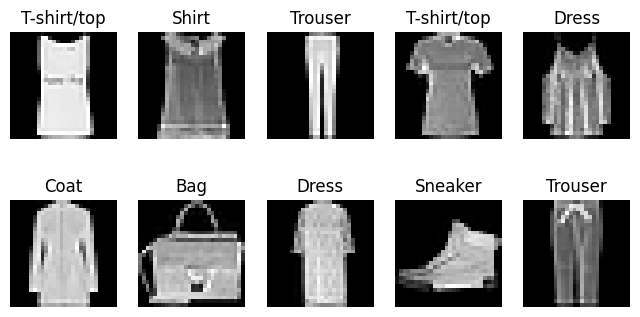

In [2]:
#Plot some Fashion MNIST examples
import matplotlib.pyplot as plt
#One batch has 64 images
dataiter = iter(train_dataloader) # Create an iterator from the DataLoader
samples = next(dataiter) # Get the next batch of data from the iterator

#Plot the data
def plot_digits(instances, labels, images_per_row = 5):
    for i in range(len(instances)):
        idx = i // images_per_row
        idy = i % images_per_row
        ax[idx, idy].imshow(instances[i].squeeze(), cmap="gray")
        ax[idx, idy].set_title(class_names[labels[i]])
        ax[idx, idy].axis("off")
        ax[idx, idy].imshow(instances[i].squeeze(), cmap="gray")

fig, ax = plt.subplots(2, 5, figsize=(8,4))
example_images = samples[0][:10]
example_labels = samples[1][:10]

plot_digits(example_images, example_labels, images_per_row=5)
plt.show()




In [3]:
#Use PyTorch to build a neural network (multi layer perceptron) for image classification
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

np.random.seed(42)
torch.manual_seed(42)

class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        self.flatten = nn.Flatten() #Convert the image from matrix to vector
        self.fc1 = nn.Linear(784, 300) #The input layer with 784 features, and the first hidden layer with 300 neurons
        self.fc2 = nn.Linear(300, 100) #The second hidden layer with 100 neurons
        self.fc3 = nn.Linear(100, 10) #The output layer with 10 classes

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))  #The first hidden layer uses ReLU activation function
        x = F.relu(self.fc2(x))  #The first hidden layer uses ReLU activation function
        x = self.fc3(x) #The output layer does not apply any activation function here, but will be processed directly by loss function
        return x

In [4]:
#Set up some hyperparameters: use cross entropy loss, adam optimizer, and epochs
import torch.optim as optim
epochs = 10
learning_rate = 0.01
weight_decay = 5e-4
lossfunction = nn.CrossEntropyLoss()

model = ClassificationNet()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

print(model)

ClassificationNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [5]:
from sklearn.metrics import f1_score

#Define the training function
def train(epoch):
    model.train()
    
    running_loss = 0.0
    train_total, train_correct = 0.0, 0.0    
    y_train, y_pred = [], []
    
    for i, (features, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()

        outputs = model(features)

        loss = lossfunction(outputs, labels.long())
        loss.backward()
        optimizer.step()
        
        #print statistics
        running_loss += loss.item()
        _, train_predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (train_predicted == labels.long()).sum().item()
        y_train += labels.tolist()
        y_pred += train_predicted.tolist()

    macro_f1 = f1_score(y_train, y_pred, average='macro')
    print("epoch (%d): Train accuracy: %.4f, f1_score: %.4f, loss: %.3f" % (epoch, train_correct/train_total, macro_f1, running_loss/train_total))
    
    
#Train the model
for epoch in range(1, epochs + 1):
    train(epoch)

epoch (1): Train accuracy: 0.7972, f1_score: 0.7951, loss: 0.009
epoch (2): Train accuracy: 0.8304, f1_score: 0.8293, loss: 0.007
epoch (3): Train accuracy: 0.8387, f1_score: 0.8376, loss: 0.007
epoch (4): Train accuracy: 0.8383, f1_score: 0.8374, loss: 0.007
epoch (5): Train accuracy: 0.8404, f1_score: 0.8395, loss: 0.007
epoch (6): Train accuracy: 0.8409, f1_score: 0.8399, loss: 0.007
epoch (7): Train accuracy: 0.8412, f1_score: 0.8402, loss: 0.007
epoch (8): Train accuracy: 0.8430, f1_score: 0.8422, loss: 0.007
epoch (9): Train accuracy: 0.8442, f1_score: 0.8431, loss: 0.007
epoch (10): Train accuracy: 0.8451, f1_score: 0.8440, loss: 0.007


In [9]:
#Evaluate the trained neural network

#Define the test function
def test():
    model.eval()
    
    test_correct, test_total = 0.0, 0.0
    y_test, y_pred = [], []
    
    with torch.no_grad():
        for features, labels in test_dataloader:
            outputs = model(features)
            
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels.long()).sum().item()
            y_test += labels.tolist()
            y_pred += predicted.tolist()

    macro_f1 = f1_score(y_test, y_pred, average='macro')
    print('Test accuracy: %.4f, macro f1_score: %.4f' % (test_correct / test_total, macro_f1))
    
    return y_test, y_pred

#Test the model
y_test, y_pred = test()


Test accuracy: 0.8318, macro f1_score: 0.8268


In [10]:
#Output the confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[879   8  16  27   0   1  56   0  13   0]
 [  3 967   2  25   1   0   0   0   2   0]
 [ 13   8 855  15  67   0  32   0  10   0]
 [ 43  18  13 882  19   0  18   0   7   0]
 [  1   7 299  63 552   0  71   0   7   0]
 [  1   1   0   0   0 881   0  90   3  24]
 [238  12 189  23  47   1 470   0  20   0]
 [  0   0   0   0   0   8   0 980   0  12]
 [  1   1  12   5   2   4  13  10 952   0]
 [  0   2   0   0   0  10   0  87   1 900]]


In [11]:
#Calculate accuracy, macro F1 and micro F1

from sklearn.metrics import accuracy_score, f1_score

acc = accuracy_score(y_test, y_pred)
macrof1 = f1_score(y_test, y_pred, average='macro')
microf1 = f1_score(y_test, y_pred, average='micro')
print('Accuracy: {:.2f}'.format(acc))
print('Macro F1-score: {:.2f}'.format(macrof1))
print('Micro F1-score: {:.2f}'.format(microf1))

Accuracy: 0.83
Macro F1-score: 0.83
Micro F1-score: 0.83
